In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import matplotlib as mpl
from tqdm import tqdm
import gc
import utils

In [2]:
# loading the region data
with open('../../../../data/mike_working_dir/identifying_regions_data/adjusted_regions.pkl', 'rb') as f:
		regions = pickle.load(f)
with open('../../../../data/mike_working_dir/identifying_regions_data/twins_era_stats_dict_radius_regions_min_2.pkl', 'rb') as f:
		stats = pickle.load(f)


data_dir = '../../../../data/'
working_dir = data_dir + 'mike_working_dir/rsd_stats/'
twins_dir = '../data/twins/'
supermag_dir = data_dir+'supermag/feather_files/'

# loading the solar wind data
omni = pd.read_feather('../data/SW/omniData.feather')
omni = omni.set_index('Epoch', drop=True)
omni.index = pd.to_datetime(omni.index)

storm_list = pd.read_csv('StormList_types.csv')
storm_list['initial_phase'] = pd.to_datetime(storm_list['initial_phase'])
storm_list['main_phase'] = pd.to_datetime(storm_list['main_phase'])
storm_list['minimumSymH'] = pd.to_datetime(storm_list['minimumSymH'])
storm_list['end_recovery_phase'] = pd.to_datetime(storm_list['end_recovery_phase'])
storm_list['new_begining_times'] = pd.to_datetime(storm_list['new_begining_times'])
storm_list['new_ending_times'] = pd.to_datetime(storm_list['new_ending_times'])

In [3]:
recalculate_regions = False

clusters = {
	'canadian_cluster':{
		'regions':{
		'CAN-0': {'stations':['NEW', 'T19', 'C10', 'LET', 'T03', 'T43']},
		'CAN-1': {'stations':['LET', 'T03', 'T43', 'RED' , 'C06']},
		'CAN-2': {'stations':['T43', 'RED', 'C06', 'MEA', 'T36']}
		}
	},
	'greenland_cluster':{
		'regions':{
		'GRL-0': {'stations':['GHB', 'SKT', 'STF', 'ATU']},
		'GRL-1': {'stations':['SKT', 'STF', 'ATU', 'GDH']},
		'GRL-2': {'stations':['STF', 'ATU', 'GDH', 'UMQ']},
		'GRL-3': {'stations':['GHB', 'FHB', 'NAQ']},
		}
	},
	'fennoscandinavian_cluster':{
		'regions':{
		'FSC-0': {'stations':['RVK', 'LYC', 'DON', 'JCK']},
		'FSC-1': {'stations':['HAN', 'MEK', 'OUJ', 'NUR']},
		'FSC-2': {'stations':['MAS', 'NOR', 'IVA', 'KEV', 'KIL', 'MUO', 'SOR', 'TRO', 'ABK', 'KIR']},
		'FSC-3': {'stations':['MAS', 'AND', 'KIL', 'MUO', 'SOR', 'TRO', 'ABK', 'KIR']},
		'FSC-4': {'stations':['MAS', 'SOD', 'IVA', 'KEV', 'KIL', 'MUO', 'ABK', 'KIR', 'PEL']},
		'FSC-5': {'stations':['JCK', 'DON', 'ABK', 'KIR', 'LYC']},
		'FSC-6': {'stations':['MAS', 'AND', 'KIL', 'MUO', 'JCK', 'TRO', 'ABK', 'KIR', 'PEL']},
		}
	},
	'central_european_cluster':{
		'regions':{
		'CEU-0': {'stations':['ZAG', 'LVV', 'BEL', 'VYH']},
		'CEU-1': {'stations':['BEL', 'HLP', 'SZC', 'KLD']},
		'CEU-2': {'stations':['THY', 'BDV', 'WIC', 'NCK', 'HRB']},
		'CEU-3': {'stations':['ROE', 'BFE', 'WNG']},
		}
	},
	'non_cluster_regions':{
		'regions':{
		'SVLB': {'stations':['BBG', 'LYR', 'HOR', 'NAL', 'HRN', 'HOP']},
		'JPN-0': {'stations':['KUJ', 'KNY', 'KAG']},
		'JPN-1': {'stations':['MMB', 'ASB', 'RIK', 'MSR']},
		'ALSK': {'stations':['CMO', 'FYU', 'PKR', 'GAK']},
		'HUD-0': {'stations':['PIN', 'ISL', 'C05']},
		'HUD-1': {'stations':['FCC', 'EKP', 'RAN', 'BLC']},
		}
	}
}

regions = {**clusters['greenland_cluster']['regions'], **clusters['canadian_cluster']['regions'],
			**clusters['fennoscandinavian_cluster']['regions'], **clusters['central_european_cluster']['regions'],
			**clusters['non_cluster_regions']['regions']}

In [4]:
simple_df = pd.DataFrame({'one':['NEW', 'OTT', np.nan], 'two':['NEW', 'OTT', np.nan], 'three':['NEW', 'NEW', 'OTT']})

mask_df = pd.DataFrame(index=simple_df.index, columns=simple_df.columns)
for row in simple_df.iterrows():
	mask_df.loc[row[0]] = row[1].duplicated(keep=False)

# using the mask df to mask the simple df
print(simple_df)
simple_df = simple_df.where(mask_df, np.nan)
print(simple_df)

for row in simple_df.iterrows():
	print(f'{row[0]}: {row[1].dropna().tolist()}')
	# printing the column names of the non-nan values
	print(f'{row[0]}: {row[1].dropna().index.tolist()}')

   one  two three
0  NEW  NEW   NEW
1  OTT  OTT   NEW
2  NaN  NaN   OTT
   one  two three
0  NEW  NEW   NEW
1  OTT  OTT   NaN
2  NaN  NaN   NaN
0: ['NEW', 'NEW', 'NEW']
0: ['one', 'two', 'three']
1: ['OTT', 'OTT']
1: ['one', 'two']
2: []
2: []


In [5]:
def getting_dbdt_dataframe(region):

	mlt_df = pd.DataFrame(index=pd.date_range(start='2009-07-20', end='2017-12-31', freq='min'))
	dbdt_df = pd.DataFrame(index=pd.date_range(start='2009-07-20', end='2017-12-31', freq='min'))
	for station in region['stations']:
		# loading the station data
		station_df = pd.read_feather(supermag_dir + station + '.feather')
		station_df.set_index('Date_UTC', inplace=True)
		station_df.index = pd.to_datetime(station_df.index)
		# cutting the data to the region time frame
		station_df = station_df[pd.to_datetime('2009-07-20'):pd.to_datetime('2017-12-31')]
		# creating the dbdt time series
		dbdt_df[station] = station_df['dbht']
		# getting the first non-nan value of the GEOLON column
		mlt_df[station] = station_df['MLT']

		region_mlt = mlt_df.median(axis=1)

	return dbdt_df, region_mlt

def calculating_rsd(region):

	# if 'dbdt_df' not in region.keys():
	# 	region['dbdt_df'] = getting_dbdt_dataframe(region)

	# dbdt_df = region['dbdt_df']
	dbdt_df, region_mlt = getting_dbdt_dataframe(region)
	rsd = pd.DataFrame(index=dbdt_df.index)
	# calculating the RSD
	for col in dbdt_df.columns:
		ss = dbdt_df[col]
		temp_df = dbdt_df.drop(col,axis=1)
		ra = temp_df.mean(axis=1)
		rsd[col] = ss-ra
	max_rsd = rsd.max(axis=1)
	max_station = rsd.idxmax(axis=1)
	rsd['max_rsd'] = max_rsd
	rsd['max_station'] = max_station
	rsd['MLT'] = region_mlt

	region['rsd_df'] = rsd

	return rsd

In [6]:
if not (os.path.exists(working_dir+'rsd_data.pkl')) or recalculate_regions:
	for region in regions.values():
		region['rsd_df'] = calculating_rsd(region)
		region['mean_lat'] = utils.getting_mean_lat(region['stations'])
	with open(working_dir+'rsd_data.pkl', 'wb') as f:
		pickle.dump(regions, f)
else:
	with open(working_dir+'rsd_data.pkl', 'rb') as f:
		regions = pickle.load(f)

In [7]:
# region_numbers = [387, 61, 202, 287, 207, 361, 137, 184, 36, 19, 9, 163, 16, 270, 194, 82,
# 								83, 143, 223, 44, 173, 321, 366, 383, 122, 279, 14, 95, 237, 26, 166, 86,
# 								62, 327, 293, 241, 107, 55, 111, 400, 401]

# regions = {f'region_{region}': regions[f'region_{region}'] for region in region_numbers}

all_stations = []
for region in regions:
	new_stations = [station for station in regions[region]['stations'] if station not in all_stations]
	all_stations += new_stations

In [8]:
# stations = {}
# for station in all_stations:
# 	df = pd.read_feather(supermag_dir+station+'.feather')
# 	df.set_index('Date_UTC', drop=True, inplace=True)
# 	df.index = pd.to_datetime(df.index)
# 	df = df['2009-07-20':'2017-12-31']
# 	stations[station] = {'geolat': df['GEOLAT'].mean()}
# 	df.drop(columns=['SZA', 'dbn_geo', 'dbe_geo', 'dbz_geo','MAGLON', 'GEOLAT', 'GEOLON'], inplace=True)
# 	stations[station]['df'] = df

In [9]:
# scandinavia_regions = ['region_14', 'region_26', 'region_44', 'region_61', 'region_86', 'region_95', 'region_122', 'region_166', 'region_173',
# 						'region_237', 'region_279', 'region_321', 'region_366', 'region_383', 'region_387']
# svalbard_regions = ['region_143', 'region_223']
# greenland_regions = ['region_62', 'region_241', 'region_293', 'region_327']
# central_europe_regions = ['region_107', 'region_137', 'region_184', 'region_202', 'region_207', 'region_287', 'region_361']
# central_canadian_regions = ['region_16', 'region_55', 'region_82', 'region_111', 'region_194', 'region_270']

In [10]:
# for region in regions:
# 	regions[region]['mean_lat'] = utils.getting_mean_lat(regions[region]['station'])

In [11]:
to_drop = {}
for cluster in clusters:
	if cluster == 'non_cluster_regions':
		continue
	repeated_df = pd.DataFrame()
	mask_df = pd.DataFrame(columns=clusters[cluster]['regions'].keys())
	max_rsd_df = pd.DataFrame()
	index_list, val_list = [], []
	for region_name, region in clusters[cluster]['regions'].items():
		repeated_df[region_name] = regions[region_name]['rsd_df']['max_station']
		max_rsd_df[region_name] = regions[region_name]['rsd_df']['max_rsd']
		to_drop[region_name] = []
	for row in repeated_df.iterrows():
		index_list.append(row[0])
		val_list.append(row[1].duplicated(keep=False))
	mask_df = pd.DataFrame(val_list, index=index_list, columns=repeated_df.columns)
	repeated_df = repeated_df.where(mask_df, np.nan)
	max_rsd_df = max_rsd_df.where(mask_df, np.nan)
	max_rsd = max_rsd_df.idxmax(axis=1)
	for row in max_rsd_df.iterrows():
		reg_list = row[1].dropna().index.tolist()
		new_list = [reg for reg in reg_list if reg != max_rsd.loc[row[0]]]
		for reg in new_list:
			to_drop[reg].append(row[0])

/tmp/ipykernel_899320/2977877500.py:19: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_rsd = max_rsd_df.idxmax(axis=1)
/tmp/ipykernel_899320/2977877500.py:19: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_rsd = max_rsd_df.idxmax(axis=1)
/tmp/ipykernel_899320/2977877500.py:19: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_rsd = max_rsd_df.idxmax(axis=1)
/tmp/ipykernel_899320/2977877500.py:19: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_rsd = max_rsd_df.idxmax(axis=1)


In [12]:
for key in to_drop.keys():
	print(f'{key}: {len(to_drop[key])}')

CAN-0: 415774
CAN-1: 1415317
CAN-2: 920426
GRL-0: 1871031
GRL-1: 2383748
GRL-2: 1775241
GRL-3: 234822
FSC-0: 1203104
FSC-1: 0
FSC-2: 2423959
FSC-3: 3205250
FSC-4: 1964635
FSC-5: 1701105
FSC-6: 2316777
CEU-0: 527029
CEU-1: 815120
CEU-2: 0
CEU-3: 0


In [13]:
# defining the latitude bins in degrees
lat_delimiter = 5

# setting a date range for the index
index_date_range = pd.date_range('2009-07-20', '2017-12-31', freq='min')

lat_dict = {}
for i in range(20, 90, lat_delimiter):
	print(f'lat: {i}')
	cluster_flag = False
	# scandinavia, svalbard, greenland, central_europe, central_canadian = pd.DataFrame(index=index_date_range), \
	# 																	pd.DataFrame(index=index_date_range), \
	# 																	pd.DataFrame(index=index_date_range), \
	# 																	pd.DataFrame(index=index_date_range), \
	# 																	pd.DataFrame(index=index_date_range)
	lat_dict[i] = {'rsd':{'df': pd.DataFrame()}, 'dbht':{'df': pd.DataFrame()}}
	for region in regions:
		temp_df = regions[region]['rsd_df']
		# temp_df = stats[region]['max_rsd']
		if regions[region]['mean_lat'] >= i and regions[region]['mean_lat'] < i + lat_delimiter:
			# if region in scandinavia_regions:
			# 	scandinavia = pd.concat([scandinavia, temp_df['max_rsd']], axis=1, ignore_index=False)
			# 	scandinavia = scandinavia.rename(columns={'max_rsd': region})
			# 	cluster_flag = True
			# elif region in svalbard_regions:
			# 	svalbard = pd.concat([svalbard, temp_df['max_rsd']], axis=1, ignore_index=False)
			# 	svalbard = svalbard.rename(columns={'max_rsd': region})
			# 	cluster_flag = True
			# elif region in greenland_regions:
			# 	greenland = pd.concat([greenland, temp_df['max_rsd']], axis=1, ignore_index=False)
			# 	greenland = greenland.rename(columns={'max_rsd': region})
			# 	cluster_flag = True
			# elif region in central_europe_regions:
			# 	central_europe = pd.concat([central_europe, temp_df['max_rsd']], axis=1, ignore_index=False)
			# 	central_europe = central_europe.rename(columns={'max_rsd': region})
			# 	cluster_flag = True
			# elif region in central_canadian_regions:
			# 	central_canadian = pd.concat([central_canadian, temp_df['max_rsd']], axis=1, ignore_index=False)
			# 	central_canadian = central_canadian.rename(columns={'max_rsd': region})
			# 	dluster_flag = True
			# else:
			temp_df = pd.concat([temp_df[['max_rsd','max_station', 'MLT']], omni], axis=1, join='inner')
			if region in to_drop.keys():
				print(f'{region}: {len(to_drop[region])}')
				print(temp_df.shape)
				temp_df.drop(to_drop[region], inplace=True)
				print(temp_df.shape)
				del to_drop[region]
			lat_dict[i]['rsd']['df'] = pd.concat([lat_dict[i]['rsd']['df'], temp_df], axis=0)
	if cluster_flag:
		# finding the non-empty cluster dataframe
		clusters = [scandinavia, svalbard, greenland, central_europe, central_canadian]
		non_empty_clusters = [cluster for cluster in clusters if not cluster.empty]
		for cluster in non_empty_clusters:
			cluster['max'] = cluster.max(axis=1)
			cluster['max_region'] = cluster.idxmax(axis=1)
			cluster.dropna(inplace=True)
			print(cluster)
			# using the idmax to get the data for that timestamp from that region and combining them all into a single dataframe
			max_cluster_df = pd.DataFrame()
			for index, row in cluster.iterrows():
				max_cluster_df = pd.concat([max_cluster_df, stats[row['max_region']]['max_rsd'].loc[index]], axis=0)

			print('max cluster df')
			print(max_cluster_df)

			# adding the omni data to the max_cluster_df
			max_cluster_df = pd.concat([max_cluster_df, omni], axis=1, join='inner')
			lat_dict[i]['rsd']['df'] = pd.concat([lat_dict[i]['rsd']['df'], max_cluster_df], axis=0)



	print('Now the stations....')
	for station in tqdm(all_stations):
		df = pd.read_feather(supermag_dir+station+'.feather')
		df.set_index('Date_UTC', drop=True, inplace=True)
		df.index = pd.to_datetime(df.index)
		df = df['2009-07-20':'2017-12-31']
		# stations[station] = {'geolat': df['GEOLAT'].mean()}
		df.drop(columns=['SZA', 'dbn_geo', 'dbe_geo', 'dbz_geo','MAGLON', 'GEOLAT', 'GEOLON'], inplace=True)
		segmented_df = df[(df['MLAT']>=i) & (df['MLAT']<i+lat_delimiter)]
		if not segmented_df.empty:
			segmented_df = pd.concat([segmented_df, omni], axis=1, join='inner')
			lat_dict[i]['dbht']['df'] = pd.concat([lat_dict[i]['dbht']['df'], segmented_df], axis=0)

	with open(working_dir+f'lat_dict_{i}.pkl', 'wb') as f:
		pickle.dump(lat_dict[i], f)

	del lat_dict[i]

	gc.collect()

lat: 20
Now the stations....


  0%|          | 0/78 [00:00<?, ?it/s]

100%|██████████| 78/78 [02:06<00:00,  1.62s/it]


lat: 25
Now the stations....


100%|██████████| 78/78 [02:05<00:00,  1.61s/it]


lat: 30
Now the stations....


100%|██████████| 78/78 [02:05<00:00,  1.61s/it]


lat: 35
Now the stations....


100%|██████████| 78/78 [02:06<00:00,  1.62s/it]


lat: 40
CEU-2: 0
(4443841, 13)
(4443841, 13)
Now the stations....


100%|██████████| 78/78 [02:11<00:00,  1.68s/it]


lat: 45
CEU-0: 527029
(4443841, 13)
(3916812, 13)
CEU-1: 815120
(4443841, 13)
(3628721, 13)
Now the stations....


100%|██████████| 78/78 [02:04<00:00,  1.60s/it]


lat: 50
CEU-3: 0
(4443841, 13)
(4443841, 13)
Now the stations....


100%|██████████| 78/78 [02:19<00:00,  1.79s/it]


lat: 55
CAN-0: 415774
(4443841, 13)
(4028067, 13)
CAN-1: 1415317
(4443841, 13)
(3028524, 13)
FSC-1: 0
(4443841, 13)
(4443841, 13)
Now the stations....


100%|██████████| 78/78 [02:13<00:00,  1.71s/it]


lat: 60
CAN-2: 920426
(4443841, 13)
(3523415, 13)
FSC-0: 1203104
(4443841, 13)
(3240737, 13)
FSC-5: 1701105
(4443841, 13)
(2742736, 13)
Now the stations....


100%|██████████| 78/78 [02:38<00:00,  2.04s/it]


lat: 65
GRL-3: 234822
(4443841, 13)
(4209019, 13)
FSC-2: 2423959
(4443841, 13)
(2019882, 13)
FSC-3: 3205250
(4443841, 13)
(1238591, 13)
FSC-4: 1964635
(4443841, 13)
(2479206, 13)
FSC-6: 2316777
(4443841, 13)
(2127064, 13)
Now the stations....


100%|██████████| 78/78 [03:11<00:00,  2.45s/it]


lat: 70
GRL-0: 1871031
(4443841, 13)
(2572810, 13)
GRL-1: 2383748
(4443841, 13)
(2060093, 13)
GRL-2: 1775241
(4443841, 13)
(2668600, 13)
Now the stations....


100%|██████████| 78/78 [02:16<00:00,  1.74s/it]


lat: 75
Now the stations....


100%|██████████| 78/78 [02:13<00:00,  1.71s/it]


lat: 80
Now the stations....


100%|██████████| 78/78 [02:02<00:00,  1.58s/it]


lat: 85
Now the stations....


100%|██████████| 78/78 [01:52<00:00,  1.44s/it]


In [14]:
select = 65
print(lat_dict[select]['rsd']['df'].columns)
print(lat_dict[select]['rsd']['df'].tail())

KeyError: 65

In [4]:
hss_df = storm_list[(storm_list['ifHSS'].isnull() == False) & (storm_list['ifCME'].isnull() == True)]
cme_df = storm_list[(storm_list['ifCME'].isnull() == False) & (storm_list['ifHSS'].isnull() == True)]
complex_df = storm_list[storm_list['ifcomplex'].isnull() == False]

In [4]:
def perc95(x):
	return np.percentile(x, 95)

def seperating_into_bins(lat_dict, analyze, dates=None, var=None, var_bins=None):

	if analyze == 'rsd':
		analyze_var_name = 'max_rsd'
	elif analyze == 'dbht':
		analyze_var_name = 'dbht'
	else:
		raise ValueError('analyze must be either rsd or dbht')

	# writing some error handling for the inputs
	if dates is not None:
		if not isinstance(dates, pd.DataFrame):
			raise ValueError('dates must be a pandas dataframe')
		if dates.shape[1] < 2:
			raise ValueError('dates must have column for start time and end time')

	if var:
		if not isinstance(var, str):
			raise ValueError('var must be a string')
		if not isinstance(var_bins, list):
			raise ValueError('var_bins must be a list')
		if len(var_bins) < 2:
			raise ValueError('var_bins must have at least two elements')

	# creating a dataframe to store the combined data
	if var:
		titles = []
		for i in range(len(var_bins)+1):
			if i == 0:
				titles.append(f'{var}<{var_bins[i]}')
			elif i < len(var_bins):
				titles.append(f'{var} between {var_bins[i-1]} and {var_bins[i]}')
			else:
				titles.append(f'{var}>{var_bins[i-1]}')
		combined_aggs = {t: pd.DataFrame() for t in titles}
	else:
		combined_aggs = pd.DataFrame()

	for lat in lat_dict:
		if lat_dict[lat][analyze]['df'].empty:
			continue
		lat_dict[lat][analyze]['df'].dropna(inplace=True)
		lat_dict[lat][analyze]['df']['MLT'] = lat_dict[lat][analyze]['df']['MLT'].astype(int)
		lat_dict[lat][analyze]['df']['MLT'].replace(24, 0, inplace=True)

		# if a dates dataframe is included, the data will be filtered to only
		# include the dates between the starting and ending dates for each row
		# of the dataframe
		if dates is not None:
			temp_df = pd.DataFrame()
			if isinstance(lat_dict[lat][analyze]['df'].index, pd.DatetimeIndex):
				lat_dict[lat][analyze]['df'].reset_index(inplace=True, drop=False)
				lat_dict[lat][analyze]['df'].rename(columns={'index': 'Date_UTC'}, inplace=True)
			lat_dict[lat][analyze]['df']['Date_UTC'] = pd.to_datetime(lat_dict[lat][analyze]['df']['Date_UTC'])
			df = lat_dict[lat][analyze]['df']
			for index, date in dates.iterrows():
				storm = df[(df['Date_UTC'] >= date['initial_phase']) & (df['Date_UTC'] <= date['end_recovery_phase'])][[analyze_var_name, 'MLT']]
				temp_df = pd.concat([temp_df, storm], axis=0)
			temp_df = temp_df.groupby('MLT').agg(['mean', 'std', 'max', 'median', perc95])[analyze_var_name]
			temp_df['lat'] = lat
			combined_aggs = pd.concat([combined_aggs, temp_df], axis=0)

		# if a variable is included, the data will be filtered to only include
		# the rows where the variable is between the values in the var_bins.
		# this will create n+1 dataframes where n is the number of bins
		if var:
			temp_df = lat_dict[lat][analyze]['df']
			if isinstance(temp_df.index, pd.DatetimeIndex):
				temp_df.reset_index(inplace=True, drop=False)
				temp_df.rename(columns={'index': 'Date_UTC'}, inplace=True)
			for i, t in enumerate(titles):
				if i == 0:
					lat_dict[lat][t] = temp_df[temp_df[var] < var_bins[i]][[analyze_var_name, 'MLT']]
				elif i < len(var_bins):
					lat_dict[lat][t] = temp_df.loc[temp_df[var].between(var_bins[i-1], var_bins[i])][[analyze_var_name, 'MLT']]
				else:
					lat_dict[lat][t] = temp_df[temp_df[var] > var_bins[i-1]][[analyze_var_name, 'MLT']]

				lat_dict[lat][t] = lat_dict[lat][t].groupby('MLT').agg(['mean', 'std', 'max', 'median', perc95])[analyze_var_name]
				lat_dict[lat][t]['lat'] = lat
				combined_aggs[t] = pd.concat([combined_aggs[t], lat_dict[lat][t]], axis=0)

		# lat_dict[lat]['rsd']['lat'] = lat

	return lat_dict, combined_aggs

lat_dict = {}
for i in range(20, 90, 5):
	with open(working_dir+f'lat_dict_{i}.pkl', 'rb') as f:
		lat_dict[i] = pickle.load(f)

rsd_bz_lat_dict, rsd_bz_combined_aggs = seperating_into_bins(lat_dict, analyze='rsd',  var='BZ_GSM', var_bins=[-2, 2])
# rsd_vx_lat_dict, rsd_vx_combined_aggs = seperating_into_bins(lat_dict, analyze='rsd', var='Vx', var_bins=[-700, -400])
# rsd_hss_lat_dict, rsd_hss_combined_aggs = seperating_into_bins(lat_dict, analyze='rsd', dates=hss_df[['initial_phase', 'end_recovery_phase']])
# rsd_cme_lat_dict, rsd_cme_combined_aggs = seperating_into_bins(lat_dict, analyze='rsd', dates=cme_df[['initial_phase', 'end_recovery_phase']])
# rsd_complex_lat_dict, rsd_complex_combined_aggs = seperating_into_bins(lat_dict, analyze='rsd', dates=complex_df[['initial_phase', 'end_recovery_phase']])

print('It got here!')
for i in range(20, 90, 5):
	del lat_dict[i]['rsd']
	gc.collect()

dbht_bz_lat_dict, dbht_bz_combined_aggs = seperating_into_bins(lat_dict, analyze='dbht', var='BZ_GSM', var_bins=[-2, 2])
# dbht_vx_lat_dict, dbht_vx_combined_aggs = seperating_into_bins(lat_dict, analyze='dbht', var='Vx', var_bins=[-700, -400])
# dbht_hss_lat_dict, dbht_hss_combined_aggs = seperating_into_bins(lat_dict, analyze='dbht', dates=hss_df[['initial_phase', 'end_recovery_phase']])
# dbht_cme_lat_dict, dbht_cme_combined_aggs = seperating_into_bins(lat_dict, analyze='dbht', dates=cme_df[['initial_phase', 'end_recovery_phase']])
# dbht_complex_lat_dict, dbht_complex_combined_aggs = seperating_into_bins(lat_dict, analyze='dbht', dates=complex_df[['initial_phase', 'end_recovery_phase']])

It got here!


In [5]:
def plot_formatting(combined_aggs, stat_value, name=None):

	# creating a meshgrid to plot the pivot table values
	mltbin = np.arange(0, 24, 1)
	latbin = np.arange(50, 85, 5)

	arr = np.asarray(mltbin)/24.*2*np.pi
	R, th = np.meshgrid(latbin, arr)

	# creating the pivot table
	if isinstance(combined_aggs, pd.DataFrame):
		plotting_dict = {name:{}}
		pivot = combined_aggs.pivot_table(index='lat', columns='MLT', values=stat_value)

		# creating a 2d array using the pivot table values and the meshgrid and filling the rest with zeros
		Z = np.zeros((len(latbin), len(mltbin)), dtype=float)
		for i, lat in enumerate(latbin):
			for mlt in mltbin:
				try:
					Z[i, mlt] = pivot.loc[lat, mlt]
				except:
					Z[i, mlt] = np.nan

		plotting_dict[name]['Z'] = Z
		plotting_dict[name]['R'] = R
		plotting_dict[name]['th'] = th
		return plotting_dict

	elif isinstance(combined_aggs, dict):
		plotting_dict = {key:{} for key in combined_aggs.keys()}
		for key in combined_aggs:
			# creating the pivot table
			pivot = combined_aggs[key].pivot_table(index='lat', columns='MLT', values=stat_value)

			# creating a 2d array using the pivot table values and the meshgrid and filling the rest with zeros
			Z = np.zeros((len(latbin), len(mltbin)), dtype=float)
			for i, lat in enumerate(latbin):
				for mlt in mltbin:
					try:
						Z[i, mlt] = pivot.loc[lat, mlt]
					except:
						Z[i, mlt] = np.nan

			plotting_dict[key]['Z'] = Z
			plotting_dict[key]['R'] = R
			plotting_dict[key]['th'] = th

	else:
		raise ValueError('combined_aggs must be a pandas dataframe or a dictionary')

	return plotting_dict

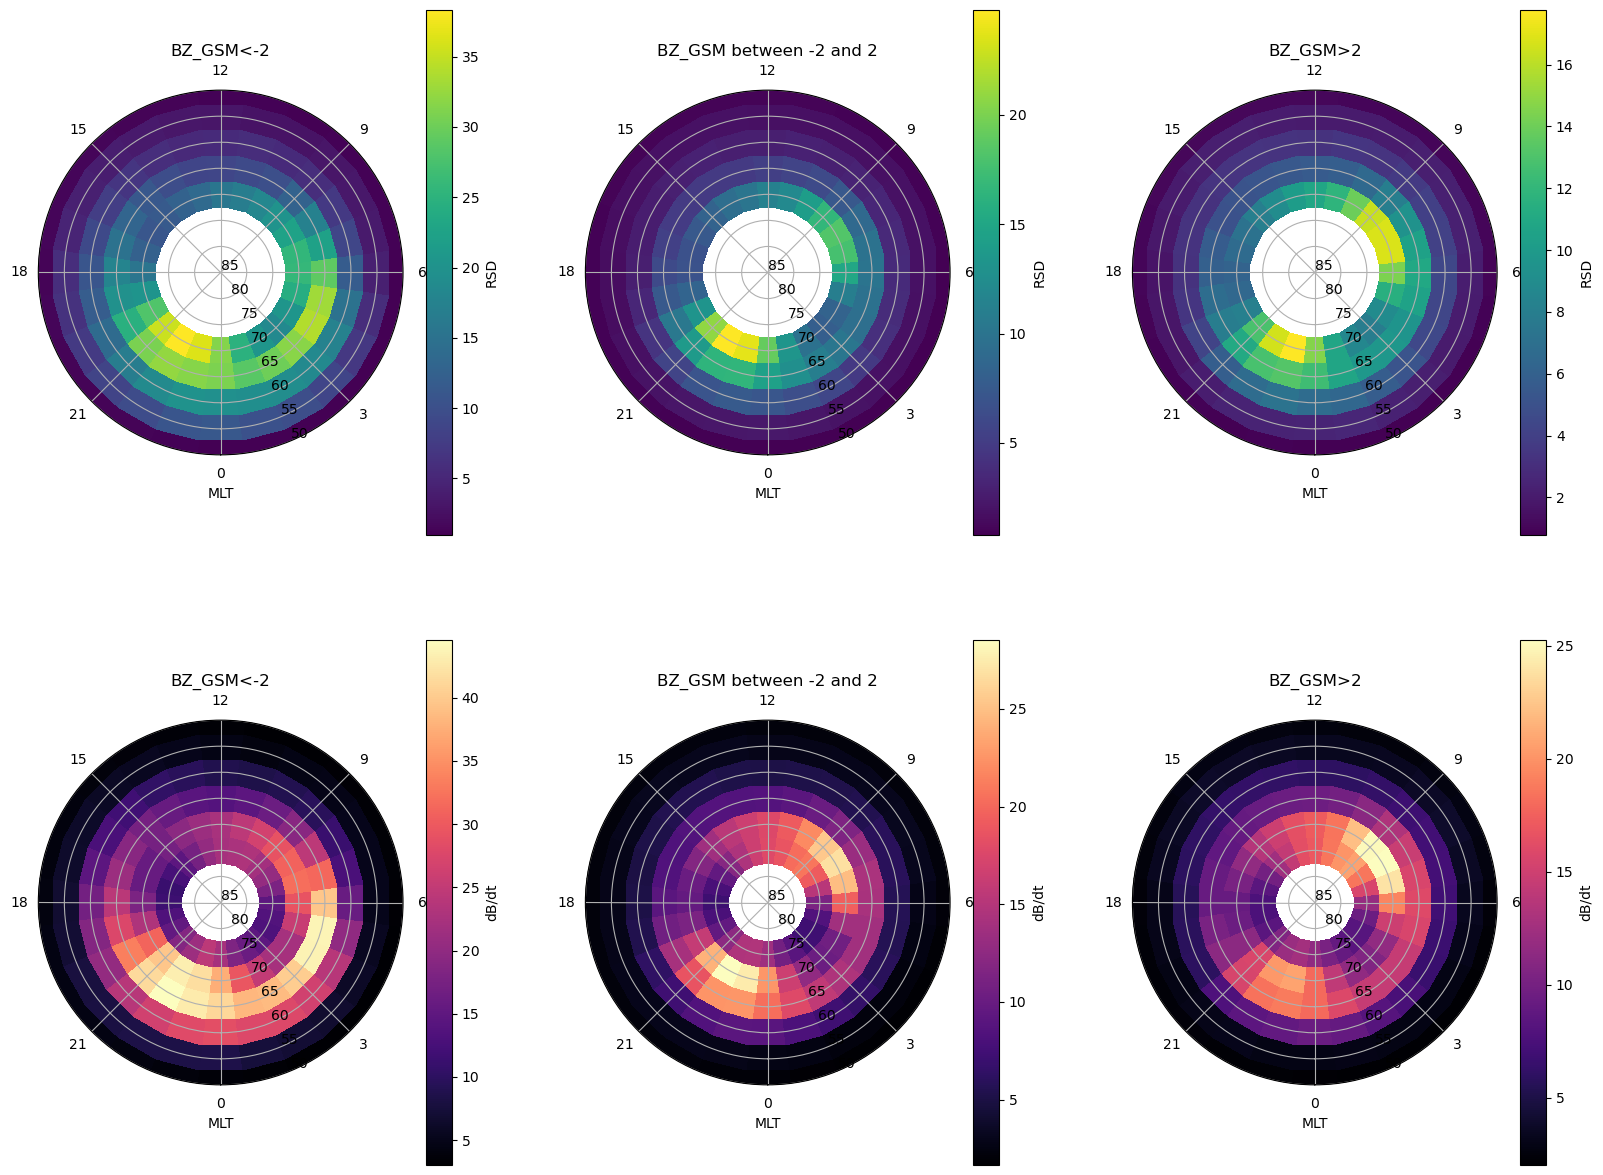

In [6]:
# plotting the heatmap using polar plot

rsd_plotting_dict = plot_formatting(rsd_bz_combined_aggs, 'perc95')
dbht_plotting_dict = plot_formatting(dbht_bz_combined_aggs, 'perc95')
fig, ax = plt.subplots(2, len(rsd_plotting_dict), figsize=(20,15), subplot_kw=dict(projection='polar'))
for i, key in enumerate(rsd_plotting_dict):
	Z = rsd_plotting_dict[key]['Z']
	R = rsd_plotting_dict[key]['R']
	th = rsd_plotting_dict[key]['th']
	c = ax[0,i].pcolormesh(th, R, Z.T, cmap='viridis', shading='auto')
	fig.colorbar(c, ax=ax[0,i], label='RSD')
	ax[0,i].set_rlim(bottom=85, top=50)
	ax[0,i].set_theta_zero_location('S')
	ax[0,i].set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
	ax[0,i].set_xlabel('MLT')
	ax[0,i].set_title(key)

for i, key in enumerate(dbht_plotting_dict):
	Z = dbht_plotting_dict[key]['Z']
	R = dbht_plotting_dict[key]['R']
	th = dbht_plotting_dict[key]['th']
	c = ax[1,i].pcolormesh(th, R, Z.T, cmap='magma', shading='auto')
	fig.colorbar(c, ax=ax[1,i], label='dB/dt')
	ax[1,i].set_rlim(bottom=85, top=50)
	ax[1,i].set_theta_zero_location('S')
	ax[1,i].set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
	ax[1,i].set_xlabel('MLT')
	ax[1,i].set_title(key)


plt.show()

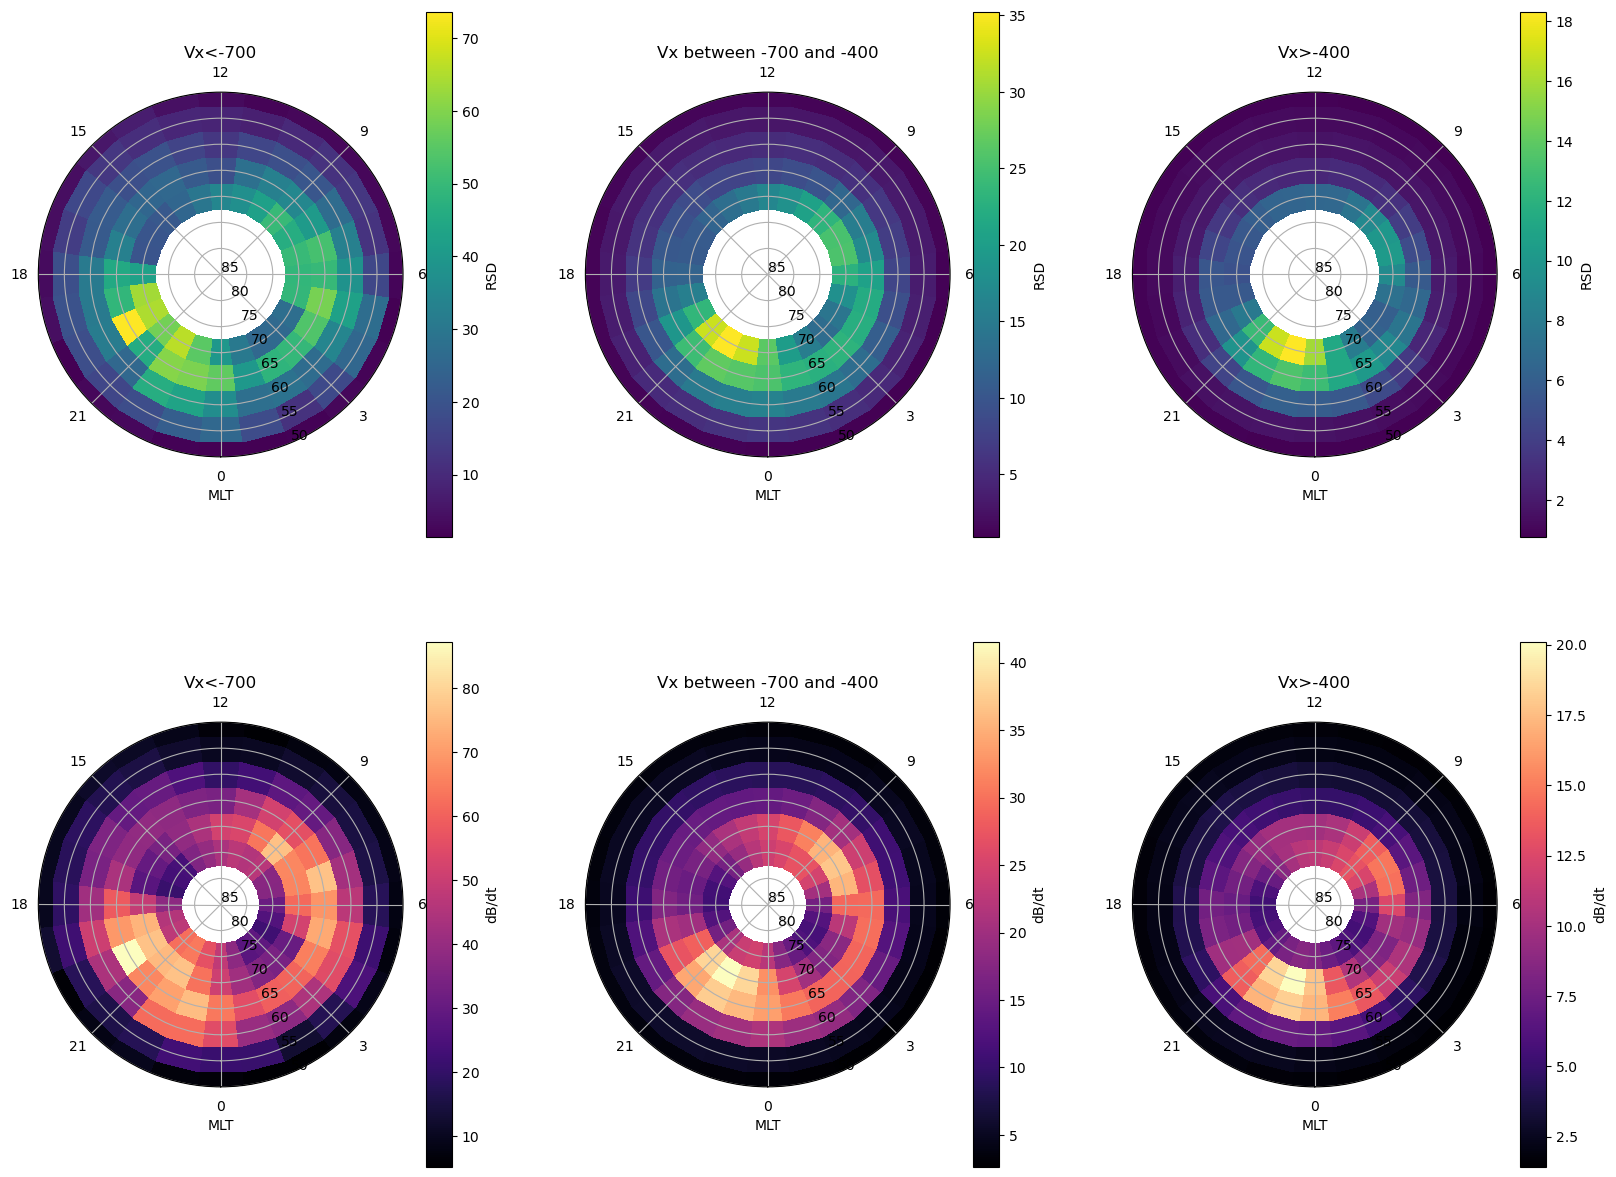

In [ ]:
# plotting the heatmap using polar plot

rsd_plotting_dict = plot_formatting(rsd_vx_combined_aggs, 'perc95')
dbht_plotting_dict = plot_formatting(dbht_vx_combined_aggs, 'perc95')
fig, ax = plt.subplots(2, len(rsd_plotting_dict), figsize=(20,15), subplot_kw=dict(projection='polar'))
for i, key in enumerate(rsd_plotting_dict):
	Z = rsd_plotting_dict[key]['Z']
	R = rsd_plotting_dict[key]['R']
	th = rsd_plotting_dict[key]['th']
	c = ax[0,i].pcolormesh(th, R, Z.T, cmap='viridis', shading='auto')
	fig.colorbar(c, ax=ax[0,i], label='RSD')
	ax[0,i].set_rlim(bottom=85, top=50)
	ax[0,i].set_theta_zero_location('S')
	ax[0,i].set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
	ax[0,i].set_xlabel('MLT')
	ax[0,i].set_title(key)

for i, key in enumerate(dbht_plotting_dict):
	Z = dbht_plotting_dict[key]['Z']
	R = dbht_plotting_dict[key]['R']
	th = dbht_plotting_dict[key]['th']
	c = ax[1,i].pcolormesh(th, R, Z.T, cmap='magma', shading='auto')
	fig.colorbar(c, ax=ax[1,i], label='dB/dt')
	ax[1,i].set_rlim(bottom=85, top=50)
	ax[1,i].set_theta_zero_location('S')
	ax[1,i].set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
	ax[1,i].set_xlabel('MLT')
	ax[1,i].set_title(key)

plt.show()

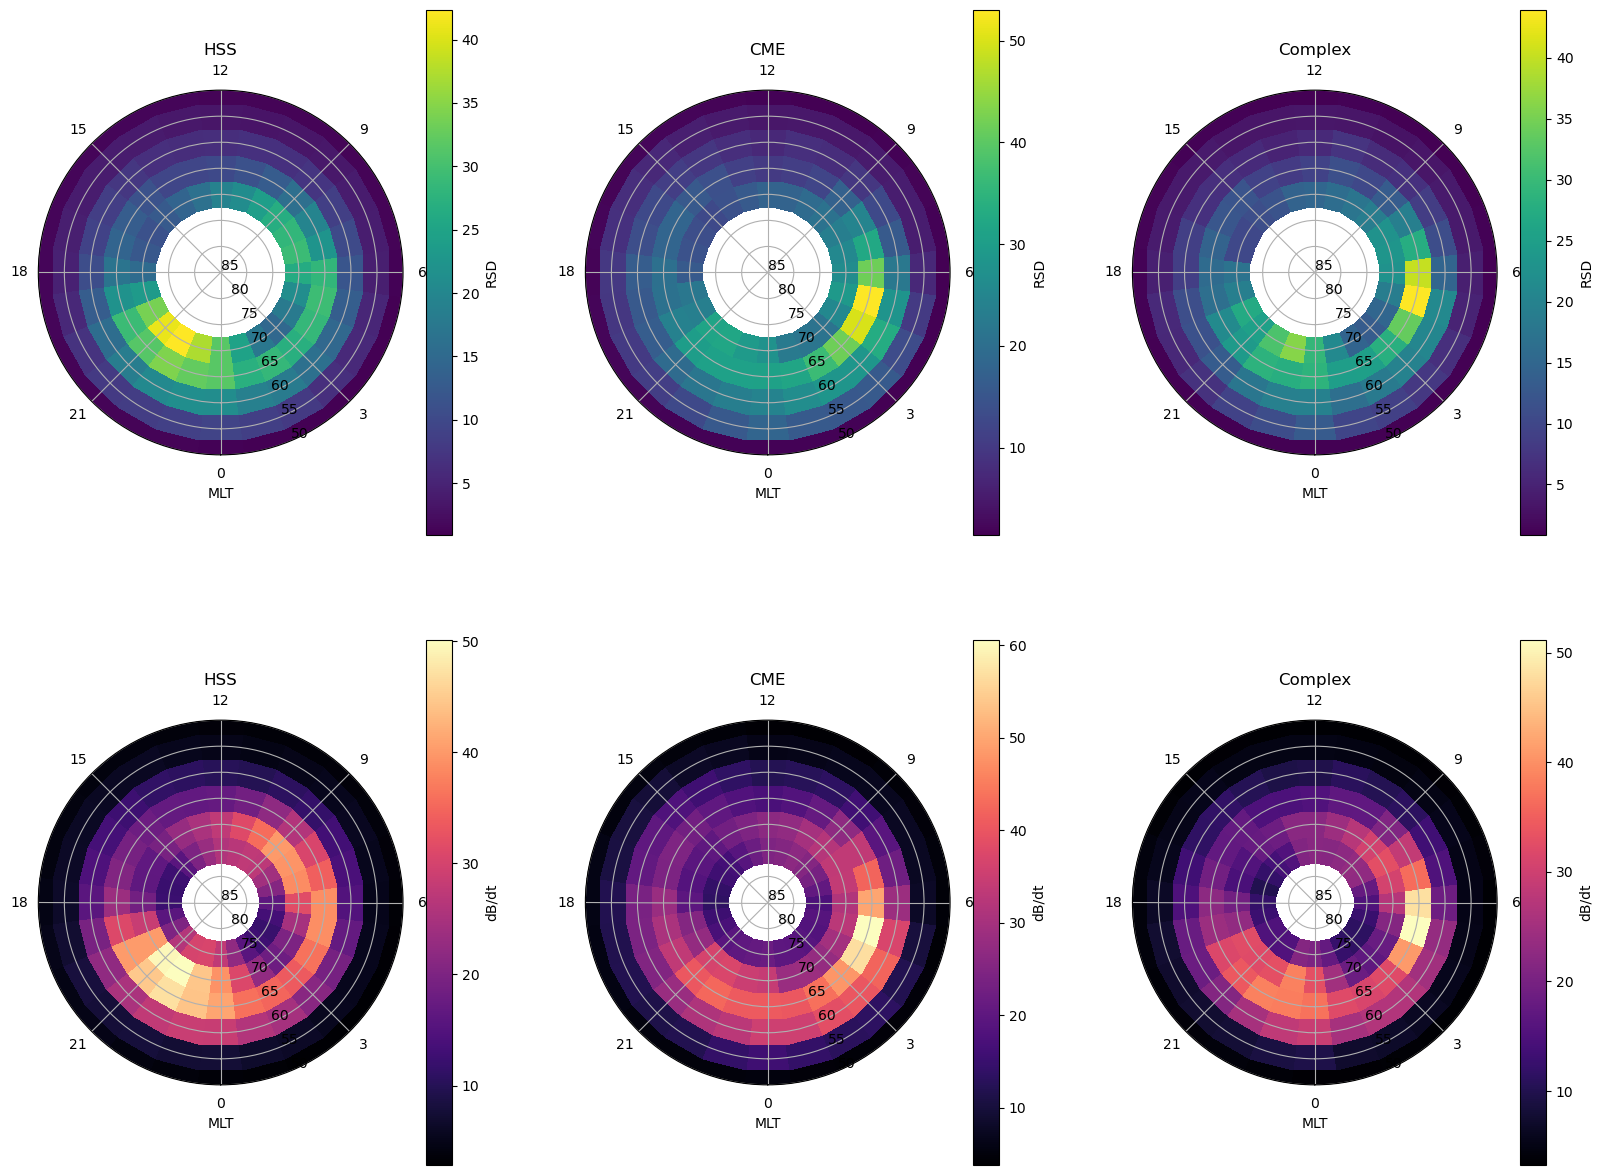

In [ ]:
# plotting the heatmap using polar plot
rsd_hss_plotting_dict = plot_formatting(rsd_hss_combined_aggs, 'perc95', name='HSS')
rsd_cme_plotting_dict = plot_formatting(rsd_cme_combined_aggs, 'perc95', name='CME')
rsd_complex_plotting_dict = plot_formatting(rsd_complex_combined_aggs, 'perc95', name='Complex')
rsd_plotting_dict = {**rsd_hss_plotting_dict, **rsd_cme_plotting_dict, **rsd_complex_plotting_dict}

dbht_hss_plotting_dict = plot_formatting(dbht_hss_combined_aggs, 'perc95', name='HSS')
dbht_cme_plotting_dict = plot_formatting(dbht_cme_combined_aggs, 'perc95', name='CME')
dbht_complex_plotting_dict = plot_formatting(dbht_complex_combined_aggs, 'perc95', name='Complex')
dbht_plotting_dict = {**dbht_hss_plotting_dict, **dbht_cme_plotting_dict, **dbht_complex_plotting_dict}

fig, ax = plt.subplots(2, len(rsd_plotting_dict), figsize=(20,15), subplot_kw=dict(projection='polar'))
for i, key in enumerate(rsd_plotting_dict):
	Z = rsd_plotting_dict[key]['Z']
	R = rsd_plotting_dict[key]['R']
	th = rsd_plotting_dict[key]['th']
	c = ax[0,i].pcolormesh(th, R, Z.T, cmap='viridis', shading='auto')
	fig.colorbar(c, ax=ax[0,i], label='RSD')
	ax[0,i].set_rlim(bottom=85, top=50)
	ax[0,i].set_theta_zero_location('S')
	ax[0,i].set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
	ax[0,i].set_xlabel('MLT')
	ax[0,i].set_title(key)

for i, key in enumerate(dbht_plotting_dict):
	Z = dbht_plotting_dict[key]['Z']
	R = dbht_plotting_dict[key]['R']
	th = dbht_plotting_dict[key]['th']
	c = ax[1,i].pcolormesh(th, R, Z.T, cmap='magma', shading='auto')
	fig.colorbar(c, ax=ax[1,i], label='dB/dt')
	ax[1,i].set_rlim(bottom=85, top=50)
	ax[1,i].set_theta_zero_location('S')
	ax[1,i].set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
	ax[1,i].set_xlabel('MLT')
	ax[1,i].set_title(key)

plt.show()

In [ ]:
# checking for common stations causing the max rsd in multiple regions
max_stations = pd.DataFrame(index=pd.date_range('2009-07-20', '2017-12-31', freq='min'))
for region in regions:
	max_stations = pd.concat([max_stations, regions[region]['rsd_df']['max_station']], axis=1, join='outer')

max_stations.columns = regions.keys()
max_stations.dropna(inplace=True, how='all')

# Getting the number of unique strings in each row of the dataframe
unique_stations = max_stations.apply(lambda row: len(row.dropna(inplace=False).unique()), axis=1)
total_stations_non_nan = max_stations.apply(lambda row: len(row.dropna(inplace=False)), axis=1)

# getting the number fo repeated stations by subtracting the number of unique stations from the total number of stations
repeated_stations = total_stations_non_nan - unique_stations

# adding the repeated stations to the max_stations dataframe
max_stations['repeated_stations'] = repeated_stations

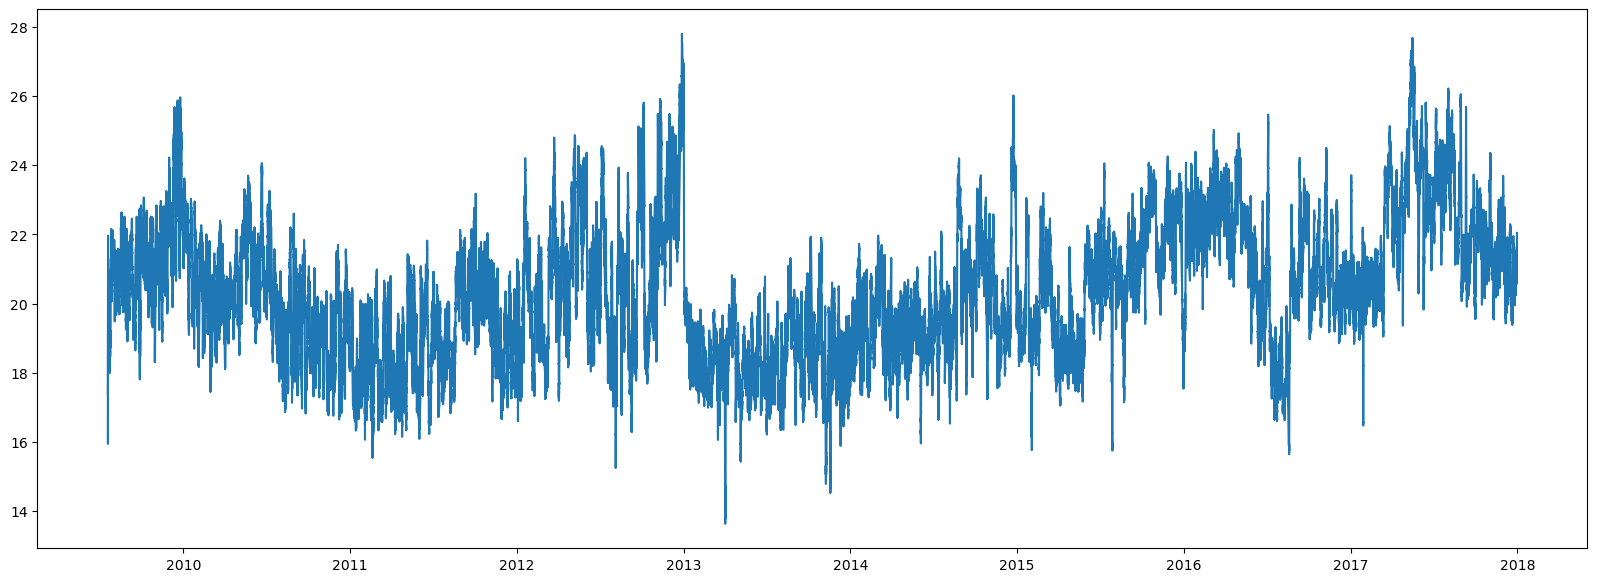

In [ ]:
perc_repeated_stations = repeated_stations/total_stations_non_nan*100

# taking the rolling mean of the percentage of repeated stations
perc_repeated_stations = perc_repeated_stations.rolling(window=1440, min_periods=1).mean()

fig, ax = plt.subplots(1,1, figsize=(20,7))
ax.plot(perc_repeated_stations, label='Percentage of repeated stations')
plt.show()